
### Importing the neccessary libraries


In [1]:
import pandas as pd
from datetime import datetime
import re
from collections import Counter
import plotly
from nltk.probability import FreqDist
import re
import pandas as pd

import folium
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import plotly.express as px
from nltk import FreqDist
import numpy as np
import seaborn as sns

### Reading the dataset

In [2]:
df_2023 = pd.read_csv('all_job_postings_9517.csv')

In [3]:

df_2023.head()

,Job Title:,Company Name:,Job Location:,Job Experience,Job Salary,Job Stats,Job Description:,Industry Type:,Required Education:,Key Skills:
0,Sr. Data Scientist,Skillety,Bangalore/Bengaluru,10 - 15 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants: 39,Strong R/Python programming skills and work ex...,Role: Data Scientist\nIndustry Type: Recruitme...,Education\nUG: Any Graduate\nPG: Any Postgraduate,Key Skills\nUnixLinuxStaffingTime managementPr...
1,Software Engineer,Talent Software4.1120 Reviews,Bangalore/Bengaluru,2 - 4 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants:...,Translate application storyboards and use case...,Role: Full Stack Developer\nIndustry Type: IT ...,Education\nUG: Any Graduate\nPG: Any Postgraduate,Key Skills\njQuerySilverlightMySQLSSRSJavascri...
2,Data Analyst - WealthTech,Mithra HR Consulting,"Mumbai, Pune",3 - 7 years,Not Disclosed,Posted: 29 days ago\nApplicants: 1161,Data Analyst - WealthTech\n\nRole : Data Analy...,Role: Data Analyst\nIndustry Type: Management ...,Education\nUG: Any Graduate\nPG: MBA/PGDM in F...,Key Skills\nSkills highlighted with ‘‘ are pre...
3,Project Associate - Public Health and CSR,Renalysis Consultants2.310 Reviews,Pune,1 - 2 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants:...,Support the development and implementation of ...,Role: Other\nIndustry Type: Management Consult...,Education\nUG: Any Graduate\nPG: Any Postgraduate,Key Skills\nData analysisLeadership developmen...
4,Senior Marketing executive,Mechuni,Bangalore/Bengaluru,1 - 4 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants: 96,We are looking for a Senior Marketing Executiv...,Role: Marketing Manager\nIndustry Type: Intern...,Education\nUG: B.B.A/ B.M.S in Management\nPG:...,Key Skills\nData analysisWeb analyticsSocial m...


###  Data Cleaning and Wrangling

#### Drop Duplicate Values

In [4]:
df_2023 = df_2023.drop_duplicates()

#### Handling missing values

In [5]:
df_2023.isnull().sum()

Job Title:             226
Company Name:          179
Job Location:            0
Job Experience           0
Job Salary               0
Job Stats                0
Job Description:         0
Industry Type:           0
Required Education:      0
Key Skills:              0
dtype: int64

In [6]:
# Filter rows where 'title' is null
null_title_rows = df_2023[df_2023['Job Title:'].isnull()]

#### Replace job titles of null value with the mode from dataset

In [7]:
# Since Job Title is categorical we are replacing null values with most common occuring job titles(mode)

mode_job_title = df_2023['Job Title:'].mode()[0]
df_2023['Job Title:'].fillna(mode_job_title, inplace=True)

In [8]:
df_2023.isnull().sum()

Job Title:               0
Company Name:          179
Job Location:            0
Job Experience           0
Job Salary               0
Job Stats                0
Job Description:         0
Industry Type:           0
Required Education:      0
Key Skills:              0
dtype: int64

## Analysis - Skills 

#### Replace "SQL" with "Sql" for extraction of texts based on First Capital letters 

In [9]:
df_2023["Key Skills:"] = df_2023["Key Skills:"].str.replace("SQL", "Sql")

#### Parse skills based on first capital letter to extract keywords

In [10]:
def split_skills(skills_string):
    skills_list = re.split(r'(?<=[a-z])(?=[A-Z])|\n', skills_string)
    # Filter out empty strings and whitespace
    skills_list = [skill.strip() for skill in skills_list if skill.strip()]
    return skills_list

# Remove "Key Skills\n" from skills string
df_2023['Key Skills:'] = df_2023['Key Skills:'].str.replace('Key Skills\n', '')
df_2023['key_skills_seperated'] = df_2023['Key Skills:'].apply(split_skills)

#### Disregard any skills that their length are less than 3

In [11]:
# Function to filter strings with length >= 3
def filter_strings(strings):
    return [s for s in strings if len(s) >= 3]

# Apply the filtering function to the "Skills" column
df_2023["key_skills_seperated"] = df_2023["key_skills_seperated"].apply(filter_strings)


#### Add Column Date so we have data when the record was collected

In [12]:
df_2023['Date'] = '2023-10-27'

In [13]:
# Define a function to remove specific words or phrases from the list
words_to_remove = [
        'Data analysis',
        'Skills highlighted with ‘‘ are preferred keyskills',
        'Analytical',
        'Analytics',
        'Monitoring',
        'Management',
        'Computer science',
        'Mining',
        'Google Ad',
        'Instrumentation',
        'Data Analysis',
        'Data Analyst'
    ]
def remove_words_from_list(skill_list, words_to_remove):
    # List of words to remove
    
    return [skill for skill in skill_list if skill not in words_to_remove]




In [14]:
df_2023["key_skills_seperated_cleaned"] = df_2023["key_skills_seperated"].apply(remove_words_from_list, words_to_remove=words_to_remove)

In [15]:
# Convert all skills to lowercase
df_2023['key_skills_seperated_cleaned_lower'] = df_2023['key_skills_seperated_cleaned'].apply(lambda x: [skill.lower() for skill in x])


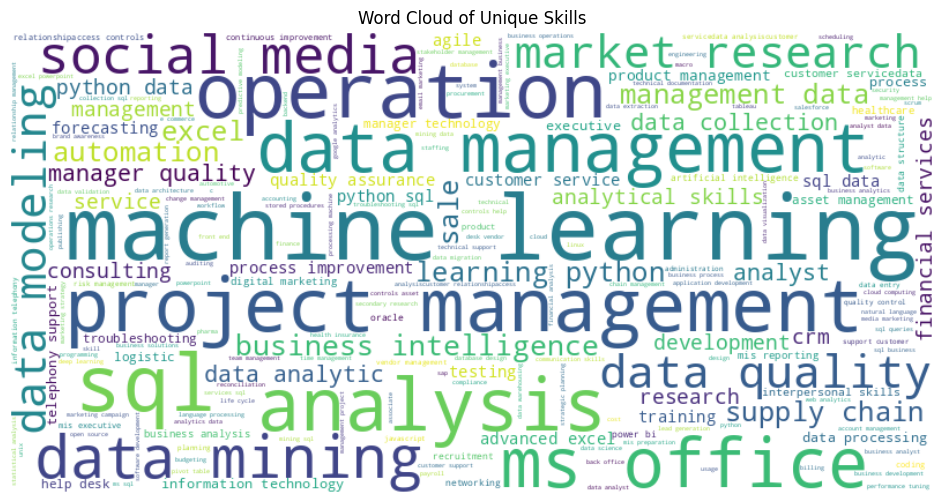

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Remove duplicates from lists of skills directly
unique_skills_lists = [set(skill_list) for skill_list in df_2023['key_skills_seperated_cleaned_lower']]
unique_skills_text_combined = ' '.join(' '.join(skill) for skill in unique_skills_lists)

# Generate a word cloud
wordcloud_combined = WordCloud(width=800, height=400, background_color='white').generate(unique_skills_text_combined)

# Plot the WordCloud image
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Unique Skills')
plt.show()




## Analysis -  Experience Level


In [17]:
# Function to preprocess 'Job Experience' values and calculate the average

def preprocess_experience(experience):
    try:
        # Check if the value is "no fixed duration"
        if experience == "no fixed duration":
            return None  # Assign a special value, such as None or NaN, to represent the lack of fixed duration
        
        # Remove 'years' and split the range
        exp_range = experience.replace(' years', '').split(' - ')
        
        # Calculate the average of the range
        avg_experience = (float(exp_range[0]) + float(exp_range[1])) / 2
        
        return avg_experience
    except (ValueError, IndexError):
        return None  # Handle unexpected values or errors

# Apply the function to create a new column 'Experience (years)'
df_2023['Average Experience (years)'] = df_2023['Job Experience'].apply(preprocess_experience)

df_2023.head()


,Job Title:,Company Name:,Job Location:,Job Experience,Job Salary,Job Stats,Job Description:,Industry Type:,Required Education:,Key Skills:,key_skills_seperated,Date,key_skills_seperated_cleaned,key_skills_seperated_cleaned_lower,Average Experience (years)
0,Sr. Data Scientist,Skillety,Bangalore/Bengaluru,10 - 15 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants: 39,Strong R/Python programming skills and work ex...,Role: Data Scientist\nIndustry Type: Recruitme...,Education\nUG: Any Graduate\nPG: Any Postgraduate,UnixLinuxStaffingTime managementProject manage...,"[Unix, Linux, Staffing, Time management, Proje...",2023-10-27,"[Unix, Linux, Staffing, Time management, Proje...","[unix, linux, staffing, time management, proje...",12.5
1,Software Engineer,Talent Software4.1120 Reviews,Bangalore/Bengaluru,2 - 4 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants:...,Translate application storyboards and use case...,Role: Full Stack Developer\nIndustry Type: IT ...,Education\nUG: Any Graduate\nPG: Any Postgraduate,jQuerySilverlightMySqlSSRSJavascriptPHPWCFWPFS...,"[Query, Silverlight, Sql, SSRSJavascript, PHPW...",2023-10-27,"[Query, Silverlight, Sql, SSRSJavascript, PHPW...","[query, silverlight, sql, ssrsjavascript, phpw...",3.0
2,Data Analyst - WealthTech,Mithra HR Consulting,"Mumbai, Pune",3 - 7 years,Not Disclosed,Posted: 29 days ago\nApplicants: 1161,Data Analyst - WealthTech\n\nRole : Data Analy...,Role: Data Analyst\nIndustry Type: Management ...,Education\nUG: Any Graduate\nPG: MBA/PGDM in F...,Skills highlighted with ‘‘ are preferred keysk...,[Skills highlighted with ‘‘ are preferred keys...,2023-10-27,[FXData Engineeringdocumentationsystems engine...,[fxdata engineeringdocumentationsystems engine...,5.0
3,Project Associate - Public Health and CSR,Renalysis Consultants2.310 Reviews,Pune,1 - 2 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants:...,Support the development and implementation of ...,Role: Other\nIndustry Type: Management Consult...,Education\nUG: Any Graduate\nPG: Any Postgraduate,Data analysisLeadership developmentCSRExcelNut...,"[Data analysis, Leadership development, CSRExc...",2023-10-27,"[Leadership development, CSRExcel, Nutrition, ...","[leadership development, csrexcel, nutrition, ...",1.5
4,Senior Marketing executive,Mechuni,Bangalore/Bengaluru,1 - 4 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants: 96,We are looking for a Senior Marketing Executiv...,Role: Marketing Manager\nIndustry Type: Intern...,Education\nUG: B.B.A/ B.M.S in Management\nPG:...,Data analysisWeb analyticsSocial mediaStrategi...,"[Data analysis, Web analytics, Social media, S...",2023-10-27,"[Web analytics, Social media, Strategic planni...","[web analytics, social media, strategic planni...",2.5


In [18]:
df_2023.columns 

Index(['Job Title:', 'Company Name:', 'Job Location:', 'Job Experience',
       'Job Salary', 'Job Stats', 'Job Description:', 'Industry Type:',
       'Required Education:', 'Key Skills:', 'key_skills_seperated', 'Date',
       'key_skills_seperated_cleaned', 'key_skills_seperated_cleaned_lower',
       'Average Experience (years)'],
      dtype='object')

In [19]:
df_2023.drop('Job Description:', axis=1, inplace=True)

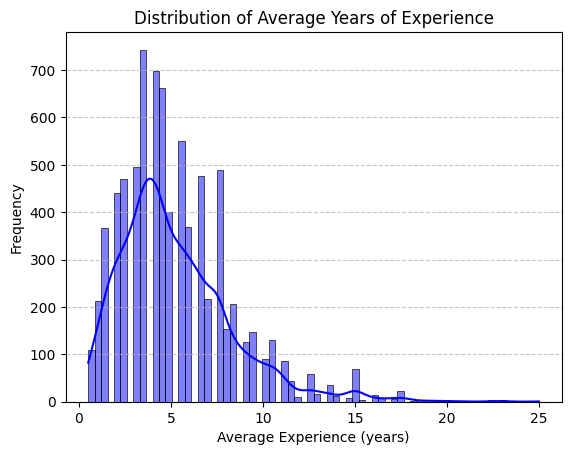

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

average_experience = df_2023['Average Experience (years)']
sns.histplot(average_experience, kde=True, color='blue', edgecolor='black')
plt.ylabel('Frequency')
plt.title('Distribution of Average Years of Experience')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [21]:
# Example: Extract skills for each experience level range
unique_exp_ranges = df_2023['Job Experience'].unique()

In [22]:
import pandas as pd
import numpy as np

# Define bins and labels for experience levels
bins = [0, 4, 10, np.inf]
labels = ['Beginner', 'Intermediate', 'Advanced']

# Create a new column 'Experience Level' based on the ranges
df_2023['Experience Level'] = pd.cut(df_2023['Average Experience (years)'], bins=bins, labels=labels, right=False)

# Display the DataFrame with the new column
df_2023


,Job Title:,Company Name:,Job Location:,Job Experience,Job Salary,Job Stats,Industry Type:,Required Education:,Key Skills:,key_skills_seperated,Date,key_skills_seperated_cleaned,key_skills_seperated_cleaned_lower,Average Experience (years),Experience Level
0,Sr. Data Scientist,Skillety,Bangalore/Bengaluru,10 - 15 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants: 39,Role: Data Scientist\nIndustry Type: Recruitme...,Education\nUG: Any Graduate\nPG: Any Postgraduate,UnixLinuxStaffingTime managementProject manage...,"[Unix, Linux, Staffing, Time management, Proje...",2023-10-27,"[Unix, Linux, Staffing, Time management, Proje...","[unix, linux, staffing, time management, proje...",12.5,Advanced
1,Software Engineer,Talent Software4.1120 Reviews,Bangalore/Bengaluru,2 - 4 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants:...,Role: Full Stack Developer\nIndustry Type: IT ...,Education\nUG: Any Graduate\nPG: Any Postgraduate,jQuerySilverlightMySqlSSRSJavascriptPHPWCFWPFS...,"[Query, Silverlight, Sql, SSRSJavascript, PHPW...",2023-10-27,"[Query, Silverlight, Sql, SSRSJavascript, PHPW...","[query, silverlight, sql, ssrsjavascript, phpw...",3.0,Beginner
2,Data Analyst - WealthTech,Mithra HR Consulting,"Mumbai, Pune",3 - 7 years,Not Disclosed,Posted: 29 days ago\nApplicants: 1161,Role: Data Analyst\nIndustry Type: Management ...,Education\nUG: Any Graduate\nPG: MBA/PGDM in F...,Skills highlighted with ‘‘ are preferred keysk...,[Skills highlighted with ‘‘ are preferred keys...,2023-10-27,[FXData Engineeringdocumentationsystems engine...,[fxdata engineeringdocumentationsystems engine...,5.0,Intermediate
3,Project Associate - Public Health and CSR,Renalysis Consultants2.310 Reviews,Pune,1 - 2 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants:...,Role: Other\nIndustry Type: Management Consult...,Education\nUG: Any Graduate\nPG: Any Postgraduate,Data analysisLeadership developmentCSRExcelNut...,"[Data analysis, Leadership development, CSRExc...",2023-10-27,"[Leadership development, CSRExcel, Nutrition, ...","[leadership development, csrexcel, nutrition, ...",1.5,Beginner
4,Senior Marketing executive,Mechuni,Bangalore/Bengaluru,1 - 4 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants: 96,Role: Marketing Manager\nIndustry Type: Intern...,Education\nUG: B.B.A/ B.M.S in Management\nPG:...,Data analysisWeb analyticsSocial mediaStrategi...,"[Data analysis, Web analytics, Social media, S...",2023-10-27,"[Web analytics, Social media, Strategic planni...","[web analytics, social media, strategic planni...",2.5,Beginner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,Procurement Manager,KS Smart Solutions4.73 Reviews,Chennai,5 - 8 years,Not Disclosed,Posted: 30+ days ago\nApplicants: 555,Role: Procurement / Purchase Manager\nIndustry...,"Education\nUG: B.Sc in Any Specialization, B.B...",Skills highlighted with ‘‘ are preferred keysk...,[Skills highlighted with ‘‘ are preferred keys...,2023-10-27,"[IT Procurement, procurement managementdata an...","[it procurement, procurement managementdata an...",6.5,Intermediate
8970,"Data Visualization Analyst - TRAI , Delhi",National Institute for Smart Government (NISG)...,Delhi / NCR,6 - 11 years,7-17 Lacs P.A.,Posted: 1 day ago\nOpenings: 1\nApplicants: 238,Role: Data Science & Analytics - Other\nIndust...,Education\nUG: B.Tech/B.E. in Any Specializati...,Skills highlighted with ‘‘ are preferred keysk...,[Skills highlighted with ‘‘ are preferred keys...,2023-10-27,"[Data Science, Big Data, Data Engineeringdata ...","[data science, big data, data engineeringdata ...",8.5,Intermediate
8972,MIS Executive,Right Step Consulting,Gurgaon,0 - 2 years,Not Disclosed,Posted: 30+ days ago\nOpenings: 1\nApplicants:...,Role: Non Tech Support - Non Voice\nIndustry T...,Education\nUG: Any Graduate\nPG: Post Graduati...,BPOAccountancyTallyAnalyticalBack officeFMCGKP...,"[BPOAccountancy, Tally, Analytical, Back offic...",2023-10-27,"[BPOAccountancy

In [23]:
new_df = df_2023[['Job Title:', 'Company Name:', 'Job Location:', 'Experience Level']].copy()
new_df.head()

,Job Title:,Company Name:,Job Location:,Experience Level
0,Sr. Data Scientist,Skillety,Bangalore/Bengaluru,Advanced
1,Software Engineer,Talent Software4.1120 Reviews,Bangalore/Bengaluru,Beginner
2,Data Analyst - WealthTech,Mithra HR Consulting,"Mumbai, Pune",Intermediate
3,Project Associate - Public Health and CSR,Renalysis Consultants2.310 Reviews,Pune,Beginner
4,Senior Marketing executive,Mechuni,Bangalore/Bengaluru,Beginner


## Distribution of job openings by Experience Levels 

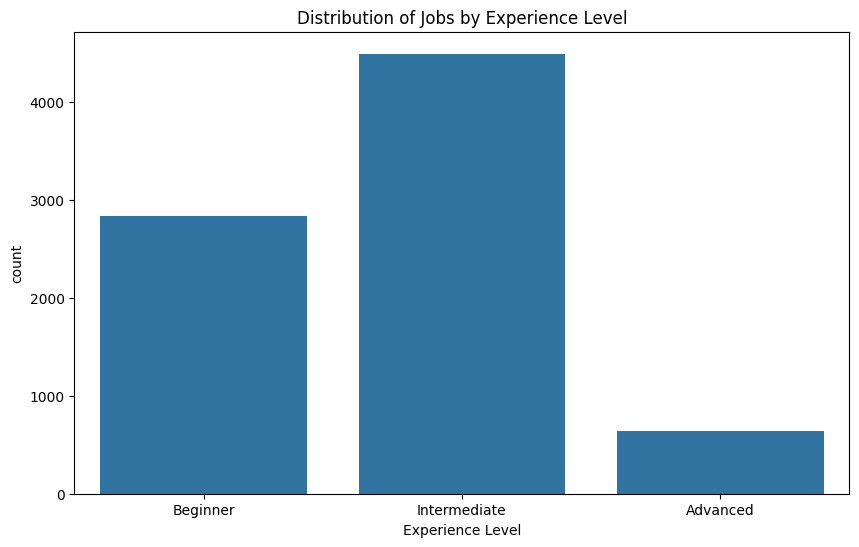

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot of Jobs by Experience Level
plt.figure(figsize=(10, 6))
sns.countplot(x='Experience Level', data=df_2023)
plt.title('Distribution of Jobs by Experience Level')
plt.show()




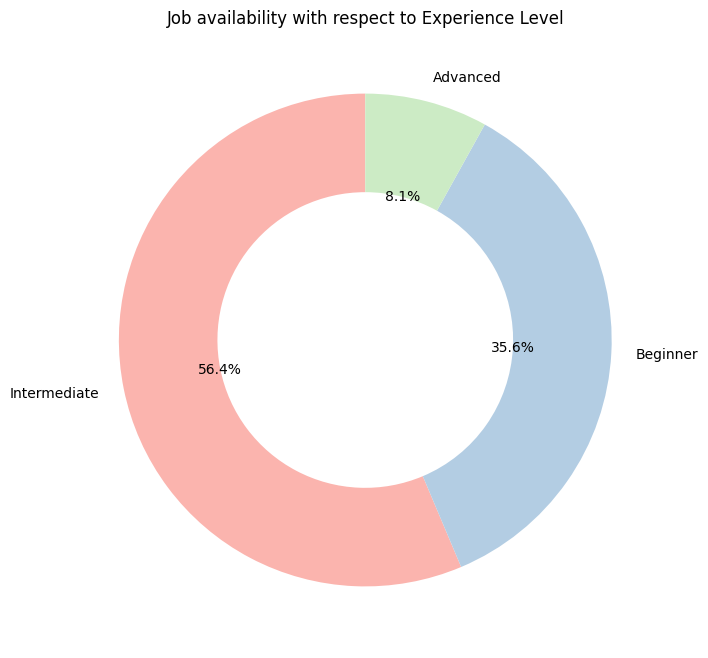

In [25]:
import matplotlib.pyplot as plt

# Get the value counts of each experience level
experience_level_counts = df_2023['Experience Level'].value_counts()
colors = plt.cm.Pastel1.colors

# Create a donut chart
plt.figure(figsize=(8, 8))
plt.pie(experience_level_counts, labels=experience_level_counts.index, autopct='%1.1f%%', startangle=90,
        wedgeprops=dict(width=0.4), colors=colors)
plt.title('Job availability with respect to Experience Level')
plt.show()


## Common Skills with respect to experience level

In [26]:
from collections import Counter



# Group skills by experience level
grouped_skills = df_2023.groupby('Experience Level')['key_skills_seperated_cleaned_lower'].apply(list)

# Function to get common skills for each experience level
def get_common_skills(skills_list, top_n=10):
    # Flatten the list of skills
    flat_skills_list = [skill for sublist in skills_list for skill in sublist]
    
    skills_count = Counter(flat_skills_list)
    common_skills = skills_count.most_common(top_n)
    return [skill[0] for skill in common_skills]

# Apply the function to get common skills for each experience level
common_skills_by_level = grouped_skills.apply(lambda x: get_common_skills(x))

# Display the common skills for each experience level
for exp_level, skills in common_skills_by_level.items():
    print(f"Experience Level: {exp_level}")
    print(f"Common Skills: {', '.join(skills)}\n")



Experience Level: Beginner
Common Skills: sql, python, excel, ms office, machine learning, data management, market research, project management, research, operations

Experience Level: Intermediate
Common Skills: sql, python, machine learning, agile, project management, automation, data management, data modeling, data mining, data quality

Experience Level: Advanced
Common Skills: sql, python, project management, machine learning, agile, automation, operations, data modeling, data management, business intelligence



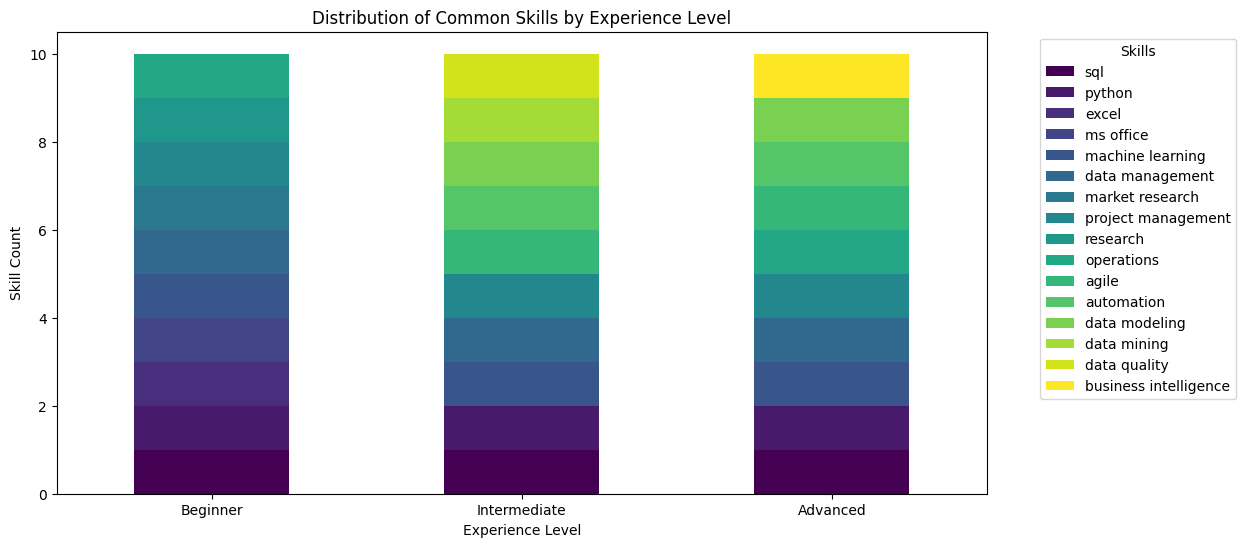

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

levels = common_skills_by_level.index
common_skills_count = [Counter(common_skills_by_level[level]) for level in levels]
df_plot = pd.DataFrame(common_skills_count, index=levels)
fig, ax = plt.subplots(figsize=(12, 6))
df_plot.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
ax.set_ylabel('Skill Count')
ax.set_xlabel('Experience Level')
ax.set_title('Distribution of Common Skills by Experience Level')
ax.set_xticks(range(len(levels)))
ax.set_xticklabels(levels, rotation=0)
plt.legend(title='Skills', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Analysis - >  Education

In [28]:
import pandas as pd
import re



def parse_to_dict(data_string):
    data_dict = {}
    lines = data_string.split('\n')
    for line in lines:
        if ":" in line:
            key_value = line.split(': ', 1)
            if len(key_value) == 2:  # Check if there are two parts after splitting
                key, value = key_value
                data_dict[key] = value
    return data_dict


df_2023['Required Education:'] = df_2023['Required Education:'].str.replace('Education\n', '')

# Apply the parsing function to the "Required Education" column and create a new column "DataDict"
df_2023['DataDict'] = df_2023['Required Education:'].apply(parse_to_dict)

# Create a new DataFrame with 'Job Title' and 'DataDict' columns
new_edu_df = df_2023[['Job Title:', 'DataDict','Experience Level']].copy()

# Rename the columns for clarity
new_edu_df.columns = ['Job Title', 'Education Requirements','Experience Level']

# Display the new DataFrame
new_edu_df



,Job Title,Education Requirements,Experience Level
0,Sr. Data Scientist,"{'UG': 'Any Graduate', 'PG': 'Any Postgraduate'}",Advanced
1,Software Engineer,"{'UG': 'Any Graduate', 'PG': 'Any Postgraduate'}",Beginner
2,Data Analyst - WealthTech,"{'UG': 'Any Graduate', 'PG': 'MBA/PGDM in Fina...",Intermediate
3,Project Associate - Public Health and CSR,"{'UG': 'Any Graduate', 'PG': 'Any Postgraduate'}",Beginner
4,Senior Marketing executive,"{'UG': 'B.B.A/ B.M.S in Management', 'PG': 'MB...",Beginner
...,...,...,...
8969,Procurement Manager,"{'UG': 'B.Sc in Any Specialization, B.B.A/ B.M...",Intermediate
8970,"Data Visualization Analyst - TRAI , Delhi","{'UG': 'B.Tech/B.E. in Any Specialization', 'P...",Intermediate
8972,MIS Executive,"{'UG': 'Any Graduate', 'PG': 'Post Graduation ...",Beginner
8974,Manager,"{'UG': 'Any Graduate', 'PG': 'CA in CA, MBA/PG...",Intermediate


In [29]:
def parse_education(data_dict):
    education_list = [f"{value}" for key, value in data_dict.items()]

    # Replace 'Any Graduate' with 'Bachelor's Degree'
    education_list = [edu.replace('Any Graduate', "Bachelor's Degree") for edu in education_list]

    # Replace 'Any Postgraduate' with 'Master's Degree'
    education_list = [edu.replace('Any Postgraduate', "Master's Degree") for edu in education_list]

    return ', '.join(education_list)

# Apply the parsing function to the "Education Requirements" column and create a new column "EducationList"
new_edu_df['EducationList'] = new_edu_df['Education Requirements'].apply(parse_education)

# Drop the 'Education Requirements' column
new_edu_df.drop('Education Requirements', axis=1, inplace=True)

# Display the updated DataFrame
new_edu_df


,Job Title,Experience Level,EducationList
0,Sr. Data Scientist,Advanced,"Bachelor's Degree, Master's Degree"
1,Software Engineer,Beginner,"Bachelor's Degree, Master's Degree"
2,Data Analyst - WealthTech,Intermediate,"Bachelor's Degree, MBA/PGDM in Finance, Doctor..."
3,Project Associate - Public Health and CSR,Beginner,"Bachelor's Degree, Master's Degree"
4,Senior Marketing executive,Beginner,"B.B.A/ B.M.S in Management, MBA/PGDM in Marketing"
...,...,...,...
8969,Procurement Manager,Intermediate,"B.Sc in Any Specialization, B.B.A/ B.M.S in An..."
8970,"Data Visualization Analyst - TRAI , Delhi",Intermediate,"B.Tech/B.E. in Any Specialization, MCA in Any ..."
8972,MIS Executive,Beginner,"Bachelor's Degree, Post Graduation Not Required"
8974,Manager,Intermediate,"Bachelor's Degree, CA in CA, MBA/PGDM in Marke..."


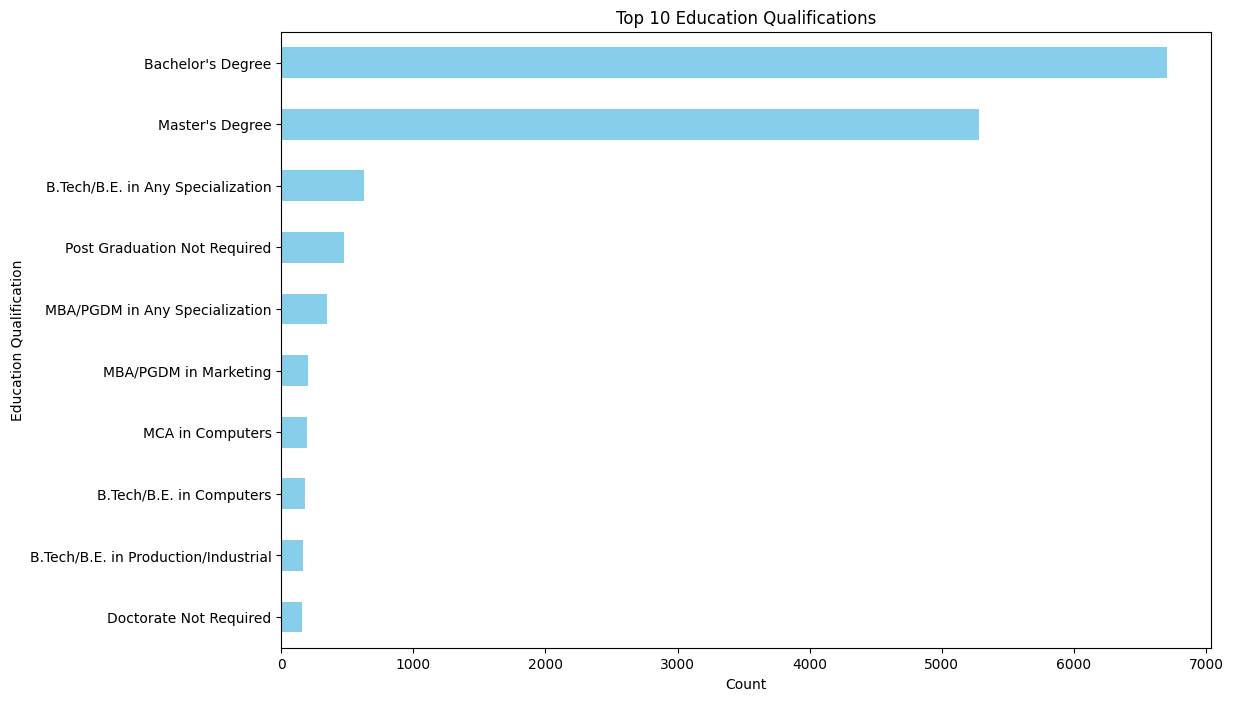

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns



# Split the education qualifications and create a list of qualifications
qualifications_list = new_edu_df['EducationList'].str.split(', ').explode()

# Count the occurrences of each qualification
qualification_counts = qualifications_list.value_counts()

# Plot a bar chart
plt.figure(figsize=(12, 8))
qualification_counts[:10].sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Education Qualifications')
plt.xlabel('Count')
plt.ylabel('Education Qualification')
plt.show()




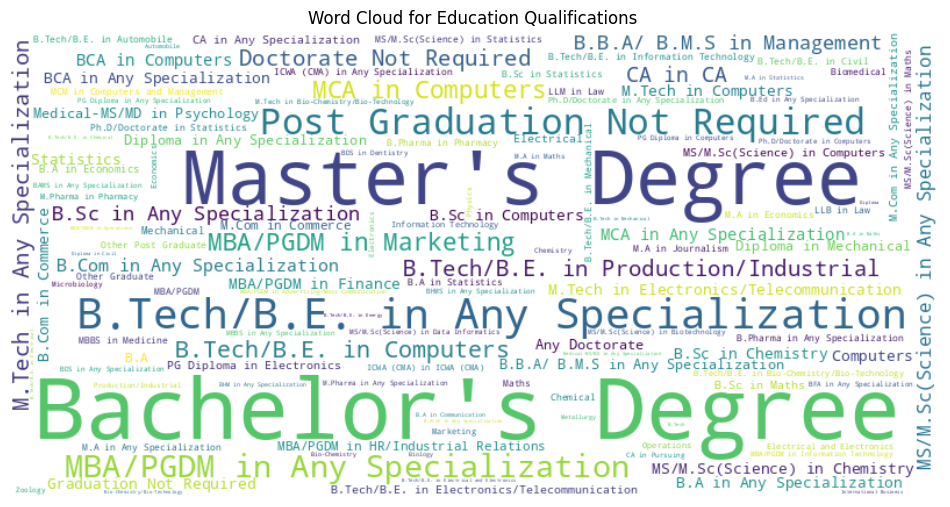

In [31]:
# Create a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(qualification_counts)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Education Qualifications ')
plt.show()


In [32]:
import pandas as pd



# Convert all columns to lowercase
new_edu_df = new_edu_df.apply(lambda x: x.astype(str).str.lower())

# Define a function to replace "sr" and "sr." with "senior"
def replace_sr(text):
    return text.replace("sr", "senior").replace("sr.", "senior")

# Apply the function to the 'Job Title:' column
new_edu_df['Job Title'] = new_edu_df['Job Title'].apply(replace_sr)



In [33]:
new_edu_df

,Job Title,Experience Level,EducationList
0,senior. data scientist,advanced,"bachelor's degree, master's degree"
1,software engineer,beginner,"bachelor's degree, master's degree"
2,data analyst - wealthtech,intermediate,"bachelor's degree, mba/pgdm in finance, doctor..."
3,project associate - public health and csenior,beginner,"bachelor's degree, master's degree"
4,senior marketing executive,beginner,"b.b.a/ b.m.s in management, mba/pgdm in marketing"
...,...,...,...
8969,procurement manager,intermediate,"b.sc in any specialization, b.b.a/ b.m.s in an..."
8970,"data visualization analyst - trai , delhi",intermediate,"b.tech/b.e. in any specialization, mca in any ..."
8972,mis executive,beginner,"bachelor's degree, post graduation not required"
8974,manager,intermediate,"bachelor's degree, ca in ca, mba/pgdm in marke..."


In [34]:
# Filter the data for Beginner experience level
beginner_data = new_edu_df[new_edu_df['Experience Level'] == 'beginner']

# Count the occurrences of each job title for beginners
job_title_counts = beginner_data['Job Title'].value_counts()

# Get the top 10 job titles for beginners
top_10_jobs_for_beginners = job_title_counts.head(10)

# Display the top 10 job titles for beginners
print("Top 10 Jobs for Beginners:")
print()
print(top_10_jobs_for_beginners)


Top 10 Jobs for Beginners:

Job Title
data scientist         141
data analyst           135
mis executive          127
data engineer           50
business analyst        45
marketing executive     27
consultant              24
executive               23
executives              14
software engineer       12
Name: count, dtype: int64


In [35]:
# Filter the data for Intermediate experience level
intermediate_data = new_edu_df[new_edu_df['Experience Level'] == 'intermediate']

# Count the occurrences of each job title for intermediate
job_title_counts = intermediate_data['Job Title'].value_counts()

# Get the top 10 job titles for intermediate
intermediate_job_titles = job_title_counts.head(10)

# Display the top 10 job titles for intermediate
print("Top Job Titles for Intermediate Level:")
print()
print(intermediate_job_titles)

Top Job Titles for Intermediate Level:

Job Title
data scientist           335
data analyst             108
data engineer             79
senior data scientist     50
business analyst          43
full stack developer      33
mis executive             29
senior data engineer      29
tableau developer         26
senior data analyst       24
Name: count, dtype: int64


In [36]:
# Filter the data for Advanced experience level
advanced_data = new_edu_df[new_edu_df['Experience Level'] == 'advanced']

# Count the occurrences of each job title for advanced
job_title_counts = advanced_data['Job Title'].value_counts()

# Get the top 10 job titles for advanced
advanced_job_titles = job_title_counts.head(10)

# Display the top 10 job titles for advanced
print("Top Job Titles for Advanced Level:")
print()
print(advanced_job_titles)

Top Job Titles for Advanced Level:

Job Title
data scientist              28
data architect              12
business analyst             7
data engineer                5
senior manager               4
scrum master                 4
senior data engineer         4
operations managers          3
staff data engineer          3
cloud solution architect     3
Name: count, dtype: int64


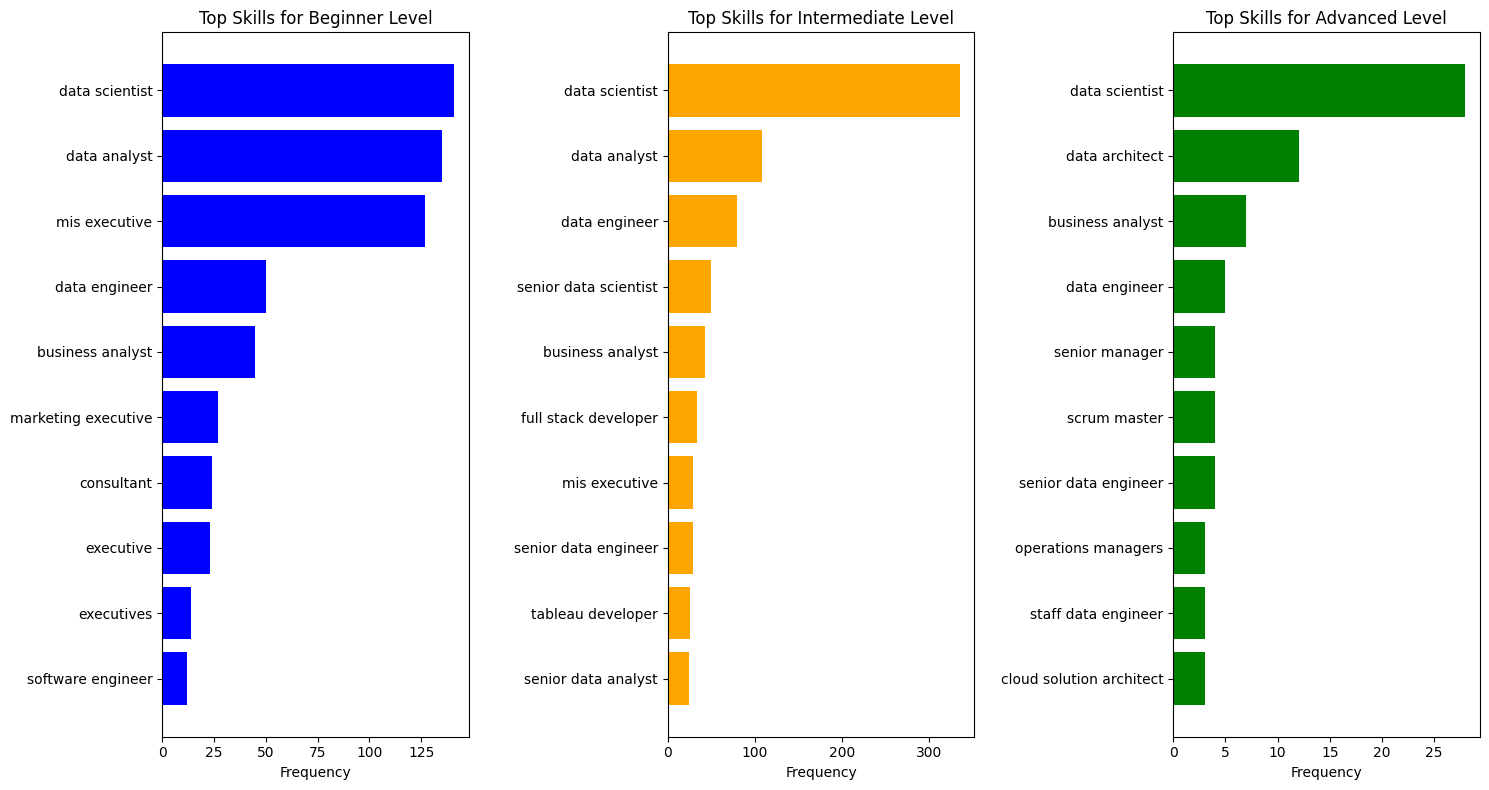

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create horizontal bar chart
def plot_horizontal_bar(ax, data, level, color):
    bars = ax.barh(np.arange(len(data)), data.values, color=color)
    ax.set_yticks(np.arange(len(data)))
    ax.set_yticklabels(data.index)
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_title(f'Top Skills for {level} Level')

# Set up subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# Plotting data for Beginner level
plot_horizontal_bar(ax1, top_10_jobs_for_beginners, 'Beginner', 'blue')

# Plotting data for Intermediate level
plot_horizontal_bar(ax2, intermediate_job_titles, 'Intermediate', 'orange')

# Plotting data for Advanced level
plot_horizontal_bar(ax3, advanced_job_titles, 'Advanced', 'green')

# Adjust layout
plt.tight_layout()
plt.show()



## Analysis - Industry

In [38]:
# Function to parse the "DataString" column into a dictionary

def parse_to_dict(data_string):
    data_dict = {}
    lines = data_string.split('\n')
    for line in lines:
        if ":" in line:
            key, value = line.split(': ', 1)
            data_dict[key] = value
    return data_dict

# Apply the parsing function to the "Industry Type" and "Required Education" column and create a new column "DataDict"
df_2023['IndustryTypeDict'] = df_2023['Industry Type:'].apply(parse_to_dict)

In [39]:
# Create a new DataFrame with "Role" and "Industry Type" columns
industry_df = df_2023['IndustryTypeDict'].apply(pd.Series)

# Display the new DataFrame
industry_df


,Role,Industry Type,Department,Employment Type,Role Category
0,Data Scientist,Recruitment / Staffing,Data Science & Analytics,"Full Time, Permanent",Data Science & Machine Learning
1,Full Stack Developer,IT Services & Consulting,Engineering - Software & QA,"Full Time, Permanent",Software Development
2,Data Analyst,Management Consulting,Data Science & Analytics,"Full Time, Permanent",Business Intelligence & Analytics
3,Other,Management Consulting,Other,"Full Time, Permanent",Other
4,Marketing Manager,Internet,Marketing & Communication,"Full Time, Permanent",Marketing
...,...,...,...,...,...
8969,Procurement / Purchase Manager,IT Services & Consulting,Procurement & Supply Chain,"Full Time, Permanent",Procurement & Purchase
8970,Data Science & Analytics - Other,IT Services & Consulting,Data Science & Analytics,"Full Time, Permanent",Data Science & Analytics - Other
8972,Non Tech Support - Non Voice,Recruitment / Staffing,"Customer Success, Service & Operations","Full Time, Permanent",Non Voice
8974,"BFSI, Investments & Trading - Other",Banking,"BFSI, Investments & Trading","Full Time, Permanent","BFSI, Investments & Trading - Other"


In [40]:
industry_df.columns

Index(['Role', 'Industry Type', 'Department', 'Employment Type',
       'Role Category'],
      dtype='object')

In [41]:
# Get the top 10 most common Industry Types
top_industry_types = industry_df['Department'].value_counts().head(5).index
top_industry_types

Index(['Data Science & Analytics', 'Engineering - Software & QA',
       'Customer Success, Service & Operations', 'Marketing & Communication',
       'Finance & Accounting'],
      dtype='object', name='Department')

In [42]:
# Print the top 5 most common departments
print("Top 5 Departments:")
print(industry_df['Department'].value_counts().head(5))

# Get the top 5 most common departments
top_departments = industry_df['Department'].value_counts().head(5).index

# Filter the data for the top 5 departments
top_departments_df = industry_df[industry_df['Department'].isin(top_departments)]

# Print the most common job roles in the top 5 departments
print("\nMost Common Job Roles in Top 5 Departments:")
print(top_departments_df['Role'].value_counts().head(10))


Top 5 Departments:
Department
Data Science & Analytics                  2578
Engineering - Software & QA               1657
Customer Success, Service & Operations     678
Marketing & Communication                  419
Finance & Accounting                       417
Name: count, dtype: int64

Most Common Job Roles in Top 5 Departments:
Role
Data Analyst                               807
Data Scientist                             487
Software Development - Other               387
Business Analyst                           363
Data Engineer                              358
MIS Executive                              268
Back End Developer                         233
Data Science & Analytics - Other           161
Data Science & Machine Learning - Other    142
Technical Lead                             123
Name: count, dtype: int64


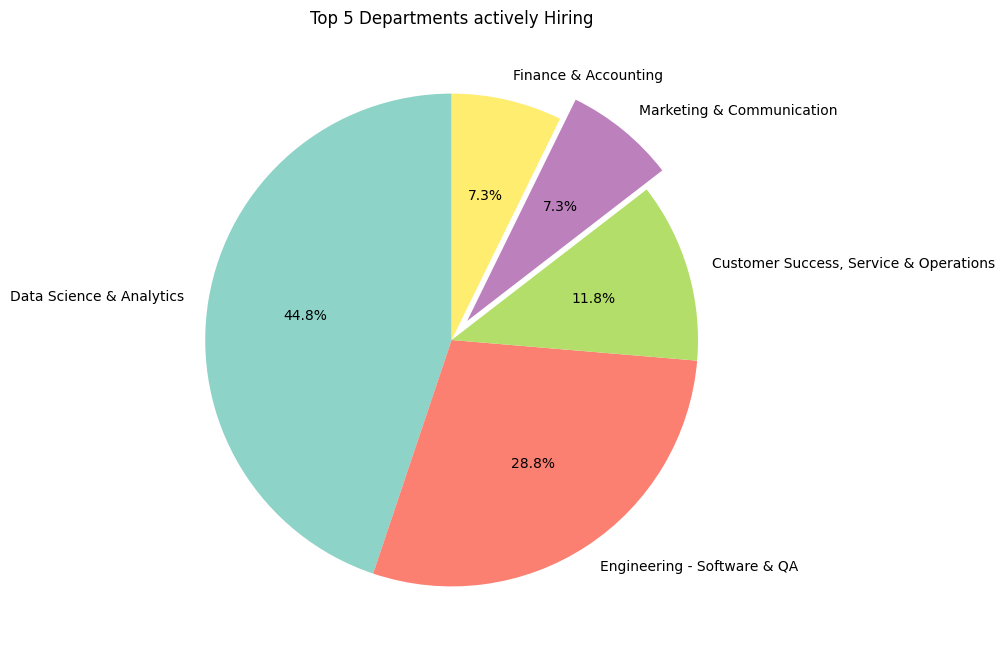

In [43]:
import matplotlib.pyplot as plt

# Create a pie chart for the distribution of roles in the top 5 departments with explode
explode = (0, 0, 0, 0.1, 0)  

plt.figure(figsize=(8, 8))
top_departments_df['Department'].value_counts().head(5).plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3', explode=explode)
plt.title('Top 5 Departments actively Hiring')
plt.ylabel('')
plt.show()


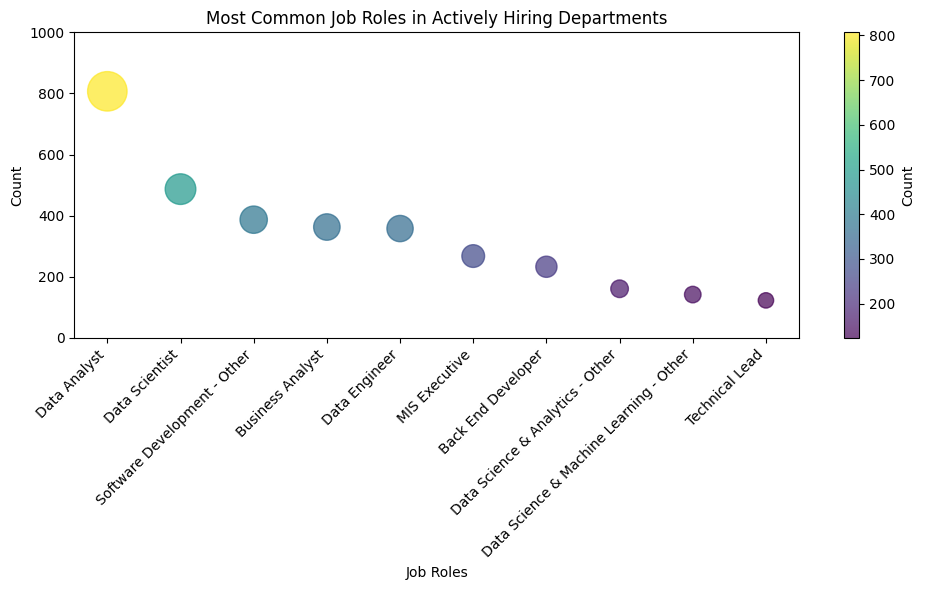

In [44]:
import matplotlib.pyplot as plt

job_roles = ["Data Analyst", "Data Scientist", "Software Development - Other", "Business Analyst",
             "Data Engineer", "MIS Executive", "Back End Developer", "Data Science & Analytics - Other",
             "Data Science & Machine Learning - Other", "Technical Lead"]
job_counts = [807, 487, 387, 363, 358, 268, 233, 161, 142, 123]
colors = job_counts
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(job_roles, job_counts, s=job_counts, c=colors, cmap='viridis', alpha=0.7)
ax.set_xlabel('Job Roles')
ax.set_ylabel('Count')
ax.set_title('Most Common Job Roles in Actively Hiring Departments')
ax.set_ylim(0, 1000)
plt.colorbar(scatter, label='Count')  
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()


